<a href="https://colab.research.google.com/github/sanglee/BIML2021/blob/main/BIML21_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BIML 2021 (Introduction to SVM)

@author: Sangkyun Lee  (sangkyun@korea.ac.kr)



### Supplementary Notes
---

In [2]:
# A utility function to plot decision boundaries in 2D

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)]*sum(y == cl),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

---
### Loading the IRIS data

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', names= ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Label'])

In [4]:
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# Prepare data matrix and labels

import numpy as np
from sklearn.preprocessing import LabelEncoder

feat_idx = [2,3]
feat_labels = df.columns[feat_idx]
X = df.iloc[:, feat_idx].values
y = df.iloc[:, 4].values
enc_y = LabelEncoder()
enc_y.fit(y)
y = enc_y.transform(y)
feature_names = df.columns.values[[2,3]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

---
## Support Vector Machine (SVM)


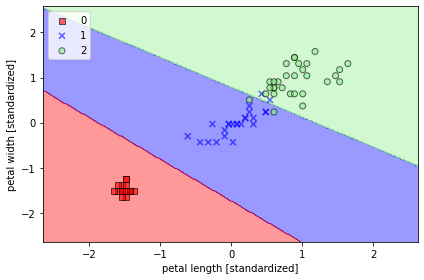

Train accuracy: 0.945205
Test accuracy: 0.977778


In [6]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

svm = SVC(decision_function_shape='ovr', kernel='linear', C=10.0)

svm.fit(X_train_std, y_train)           # standardization is recommended for numerical reasons here

plot_decision_regions(X_train_std,           
                      y_train,
                      classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(svm.predict(X_train_std), y_train))
print('Test accuracy: %f' % accuracy_score(svm.predict(X_test_std), y_test))

### Feature Importance

- Linear models (logistic regression, linear SVM, perceptron, ...)
  - Prediction for an input $x^{(i)}$ is produced by $\hat y^{(i)} = f(w^T x^{(i)})$, where $f$ is some function, e.g., to convert linear output to binary outcome.
  - $w^T x^{(i)} = \sum_{j=1}^p w_j x^{(i)}_j$ 
  - We call $w_1, w_2, \dots, w_p$ as **coefficients**, **weights**, or **learning parameters**
  - In scikit-learn, `<model>.coef_` contains the coefficients
  
- Non-linear models (decision trees, random forest, nonlinear SVM, ...)
  - This type of models provides other ways to measure feature importance
    - DT, RF: `<model>.feature_importances_`
  - In some models, it is not easy to extract feature importance
    - Nonlinear SVM

In [7]:
print(svm.coef_)

imporant_feat = pd.DataFrame(np.abs(svm.coef_))
imporant_feat.columns = feat_labels
imporant_feat

[[-1.06139348 -1.1489091 ]
 [-0.57330686 -0.57625103]
 [-2.65965384 -4.01574174]]


,Petal Length,Petal Width
0,1.061393,1.148909
1,0.573307,0.576251
2,2.659654,4.015742


---
## Nonlinear Classification

### XOR Toy Data

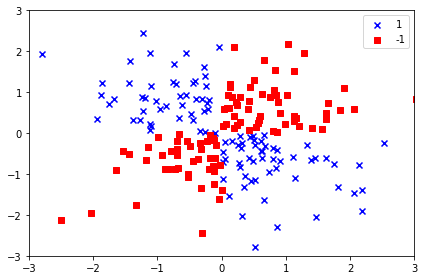

In [8]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### SVM on XOR data

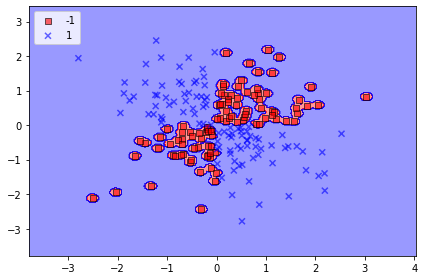

In [13]:
#
# SVM on XOR data
#
svm = SVC(kernel='rbf', random_state=1, gamma=250, C=10)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Support Vectors

In [14]:
svm.support_
#svm.support_vectors_
#svm.n_support_

array([  1,   6,   9,  11,  13,  15,  16,  17,  19,  20,  23,  24,  26,
        28,  29,  33,  35,  36,  39,  40,  41,  42,  44,  45,  46,  47,
        51,  58,  59,  60,  61,  63,  65,  69,  70,  71,  72,  73,  74,
        75,  76,  78,  80,  83,  91,  92,  93,  95,  96,  98,  99, 102,
       103, 105, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121,
       125, 128, 132, 133, 135, 136, 137, 140, 141, 142, 143, 145, 147,
       148, 151, 155, 157, 159, 160, 162, 165, 166, 168, 169, 173, 175,
       177, 179, 184, 187, 190, 191, 193, 194,   0,   2,   3,   4,   5,
         7,  10,  12,  14,  18,  21,  22,  25,  27,  30,  31,  32,  34,
        37,  38,  43,  48,  49,  50,  52,  53,  54,  55,  56,  57,  62,
        64,  66,  67,  68,  77,  79,  81,  82,  84,  85,  86,  87,  88,
        89,  90,  94,  97, 100, 101, 104, 106, 107, 108, 112, 119, 122,
       123, 124, 126, 127, 129, 130, 131, 134, 138, 139, 144, 146, 149,
       150, 152, 153, 154, 156, 158, 161, 163, 164, 167, 170, 17

In [15]:
svm.dual_coef_

array([[-8.34932563e-01, -1.02317930e+00, -8.84092839e-01,
        -1.02580855e+00, -8.77945155e-01, -9.38486913e-01,
        -6.72441248e-01, -1.02564208e+00, -1.02618601e+00,
        -8.20796050e-01, -1.02584507e+00, -8.69289086e-01,
        -1.02606427e+00, -8.84372902e-01, -1.00058747e+00,
        -1.02593921e+00, -9.79180222e-01, -8.17556896e-01,
        -8.32234366e-01, -9.19359010e-01, -1.02526061e+00,
        -9.47034578e-01, -8.15261089e-01, -1.02028744e+00,
        -8.58376866e-01, -1.00329760e+00, -1.02549859e+00,
        -1.02704565e+00, -7.55212950e-01, -1.11764691e+00,
        -1.02576365e+00, -1.02490266e+00, -8.02125256e-01,
        -6.80238771e-01, -1.09022389e-01, -1.02522494e+00,
        -9.56078494e-01, -7.97759434e-04, -8.41705745e-01,
        -1.02623065e+00, -1.02575352e+00, -4.42715019e-01,
        -8.34930352e-01, -1.02490170e+00, -1.02574270e+00,
        -8.09425333e-01, -8.49482669e-01, -4.59064314e-01,
        -1.02591374e+00, -9.51407549e-01, -9.96021535e-0

### SVM on IRIS data

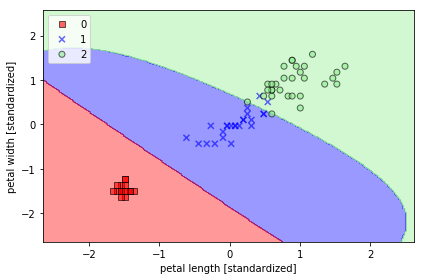

Train accuracy: 0.945205
Test accuracy: 0.977778


In [ ]:

from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma=0.2, C=1.0)  # gamma=100.0, C=1.0
svm.fit(X_train_std, y_train)

plot_decision_regions(X_train_std, y_train, classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(svm.predict(X_train_std), y_train))
print('Test accuracy: %f' % accuracy_score(svm.predict(X_test_std), y_test))

---
## K-Fold Cross Valiation (CV)

<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/06_03.png?raw=true" width=650>

In [ ]:
from sklearn.model_selection import cross_val_score

C_grid = [0.1, 1, 10]
cv_err = []

for c in C_grid:
    scores = cross_val_score(estimator=SVC(C=c),
                             X=X_train,
                             y=y_train,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1)  # no. cpu cores to use. -1 all cores
    print('C = %f' % c)
    print('CV accuracy scores:\n %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print('--------------------------------------------------------------------')
    cv_err.append(np.mean(scores))
    
best_idx = np.argmax(cv_err)
print(best_idx)
best_C = C_grid[best_idx]

print('Best C due to CV: %f' % best_C)

C = 0.100000
CV accuracy scores:
 [1.         0.93333333 0.93333333 0.86666667 1.        ]
CV accuracy: 0.947 +/- 0.050
--------------------------------------------------------------------
C = 1.000000
CV accuracy scores:
 [1.         0.93333333 0.93333333 0.86666667 1.        ]
CV accuracy: 0.947 +/- 0.050
--------------------------------------------------------------------
C = 10.000000
CV accuracy scores:
 [1.         0.93333333 0.86666667 0.86666667 1.        ]
CV accuracy: 0.933 +/- 0.060
--------------------------------------------------------------------
0
Best C due to CV: 0.100000
